# MINER Example Analysis
## I. Preparation

### 1. Import dependencies and setup environment

Import a few Python libraries that we need for our data analysis. We also need to tell MINER where the input data resides and where the results should go. We assume that the reference data was downloaded from (https://networks.systemsbiology.net/downloads/miner-examples/miner_mindata.tar.gz) and resides in the directory `miner_mindata`.

MINER requires an expression matrix, and if available an identifier mapping file. See the `identifier_mappings.txt` file for an example of the structure of the mapping file. The `preprocess()` function prepares the input file into a pandas data frame that can be used for the subsequent steps.

In [1]:
!pip install threadpoolctl --upgrade

In [2]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from miner import miner, causal_inference as causalinf
from miner import subtypes
%matplotlib inline
plt.style.use('ggplot')

DATA_DIR = "/users/imukherj/Documents/GBM/MINER/PDGSC_bulkTreated/miner3/miner/data/data_anal/"
OUTPUT_DIR = "/users/imukherj/Documents/GBM/MINER/PDGSC_bulkTreated/miner3/miner/data/data_anal/outputs/new"

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Load expression Data
expression_path = os.path.join(DATA_DIR, "Count_matrix_s1to6_CPM_miner.csv")
idmap_path = os.path.join(DATA_DIR, "identifier_mappings.txt")
exp_data, conv_table = miner.preprocess(expression_path, idmap_path)

completed z-transformation.
completed identifier conversion.
19126 genes were converted. 25470 genes were dropped due to identifier mismatch


In [3]:
exp_data.head()

,1,10,11,12,13,14,15,16,17,18,...,586,587,588,589,590,591,592,593,594,595
ENSG00000204919,-0.135347,-0.135347,-0.135347,-0.135347,-0.135347,-0.135347,-0.135347,-0.135347,-0.135347,-0.135347,...,-0.135347,-0.135347,-0.135347,-0.135347,-0.135347,-0.135347,9.738698,-0.135347,-0.135347,-0.135347
ENSG00000198400,0.170462,0.612259,-1.030894,-1.030894,-1.030894,-1.030894,-1.030894,0.401127,0.087079,0.216446,...,0.395305,0.160940,-1.030894,-1.030894,-1.030894,-1.030894,0.196193,0.731114,0.537568,1.130109
ENSG00000104267,1.008874,1.002281,-0.115811,0.878874,0.894459,0.987847,0.981066,0.835746,0.527970,0.973740,...,-0.362368,-0.934671,-1.160439,-0.693547,-1.618733,-0.626608,-0.098770,-2.665820,-0.652283,-0.381445
ENSG00000162882,-0.258753,-0.258753,-0.258753,-0.258753,-0.258753,-0.258753,-0.258753,-0.258753,-0.258753,-0.258753,...,-0.258753,-0.258753,-0.258753,-0.258753,-0.258753,-0.258753,-0.258753,-0.258753,-0.258753,-0.258753
ENSG00000145391,0.160363,0.103806,1.426872,-0.178535,0.280961,0.206458,0.146118,0.070062,0.004910,0.018090,...,-1.394561,-1.071580,-0.867295,-1.154662,1.229283,-1.359452,-0.987107,-0.014481,-1.266185,-2.024357


In [3]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from miner import miner, causal_inference as causalinf
from miner import subtypes
%matplotlib inline
plt.style.use('ggplot')

### 2. Visualizing the pre-processed expression data

It can be helpful to see a visual representation of the structure of the input data. The section below helps with that.

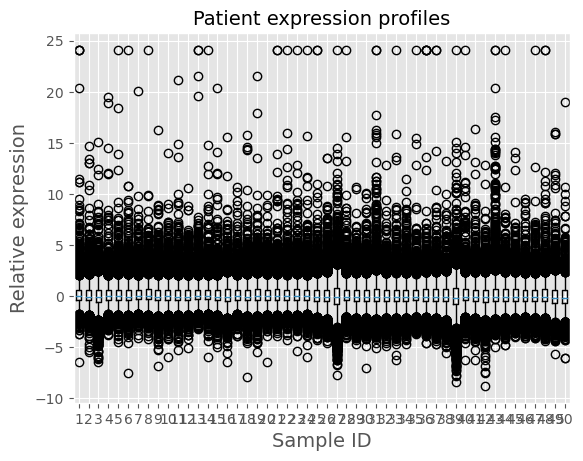

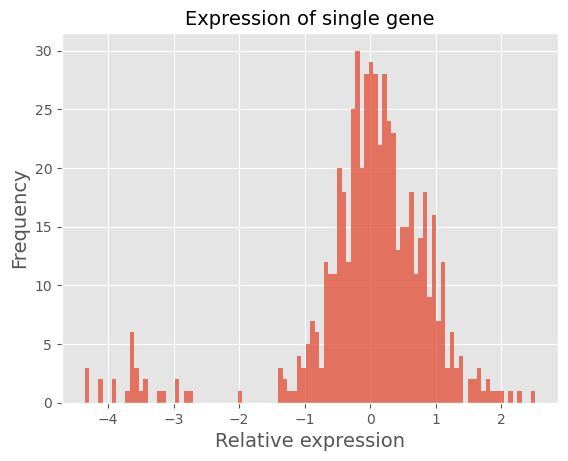

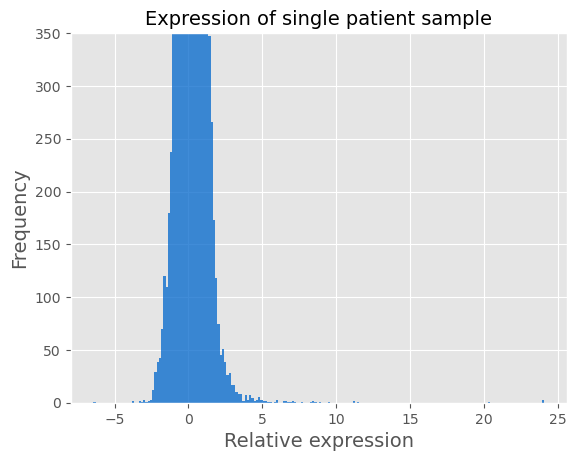

In [4]:
individual_exp_data = [exp_data.iloc[:,i] for i in range(50)]
plt.boxplot(individual_exp_data)
plt.title("Patient expression profiles", fontsize=14)
plt.ylabel("Relative expression", fontsize=14)
plt.xlabel("Sample ID", fontsize=14)
plt.figure()

plt.hist(exp_data.iloc[0,:], bins=100, alpha=0.75)
plt.title("Expression of single gene", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("Relative expression", fontsize=14)
plt.figure()

plt.hist(exp_data.iloc[:,0], bins=200, color=[0,0.4,0.8], alpha=0.75)
plt.ylim(0, 350)
plt.title("Expression of single patient sample", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
_ = plt.xlabel("Relative expression", fontsize=14)

## I. Co-expression Clustering

### 1. Setting up parameters

In [5]:
# minimum number of genes that form an acceptable coexpression cluster:
MIN_NUMBER_GENES = 6 # bulk RNAseq default=6; single cell RNAseq default=6

# minimum correlation coefficient for an acceptable regulator-cluster association 
MIN_CORRELATION = 0.2 # bulk RNAseq default=0.2; single cell RNAseq default=0.05

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
MIN_NUMBER_REGULON_GENES = 5 # bulk RNAseq default=5; single cell RNAseq default=4

# choose TF database
TFDB_PATH = os.path.join(DATA_DIR, "network_dictionaries", "tfbsdb_tf_to_genes.pkl")

# number of cores to use for parallel computation. Some functions run very slowly
# without parallel computation
NUM_CORES = 5

### 2. Run clustering and write results

In [6]:
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initial_clusters = miner.cluster(exp_data,
                                 minNumberGenes=MIN_NUMBER_GENES,
                                 minNumberOverExpSamples=4,
                                 maxSamplesExcluded=0.50,
                                 random_state=17,
                                 overExpressionThreshold=80)

# revise initial_clusters to combine highly correlated clusters and keep only those with significant coexpression
revised_clusters = miner.reviseInitialClusters(initial_clusters, exp_data)

# write revised_clusters to .json file
miner.write_json(revised_clusters, os.path.join(OUTPUT_DIR, "coexpressionDictionary.json"))

Progress: |██████████████████████████████████████████████████| 100.0% Complete

coexpression clustering completed in 3.08 minutes


In [7]:
revised_clusters = miner.read_json(os.path.join(OUTPUT_DIR, "coexpressionDictionary.json"))

### 3. Visualize the first n clusters (n=3)

In [8]:
FIRST_N = 3

first_n_clusters = np.hstack([revised_clusters[i] for i in np.arange(FIRST_N).astype(str)])

#### Background Expression

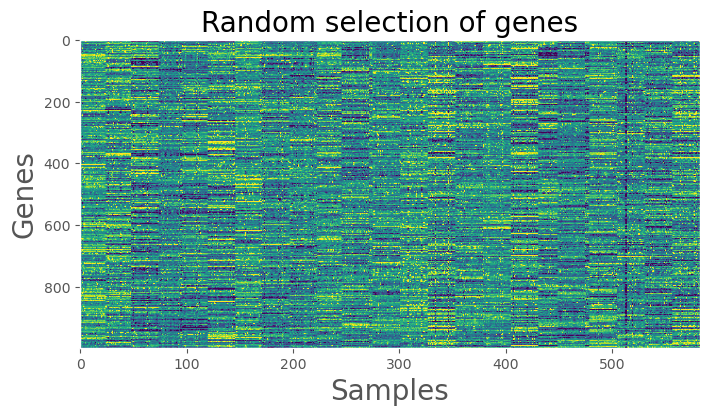

In [9]:
plt.figure(figsize=(8,4))
plt.imshow(exp_data.loc[np.random.choice(exp_data.index,len(first_n_clusters),
                                         replace=False),:],
           aspect="auto",
           cmap="viridis",
           vmin=-1,
           vmax=1)
plt.grid(False)
plt.ylabel("Genes", fontsize=20)
plt.xlabel("Samples", fontsize=20)
_ = plt.title("Random selection of genes", fontsize=20)

### Expression of the first n clusters

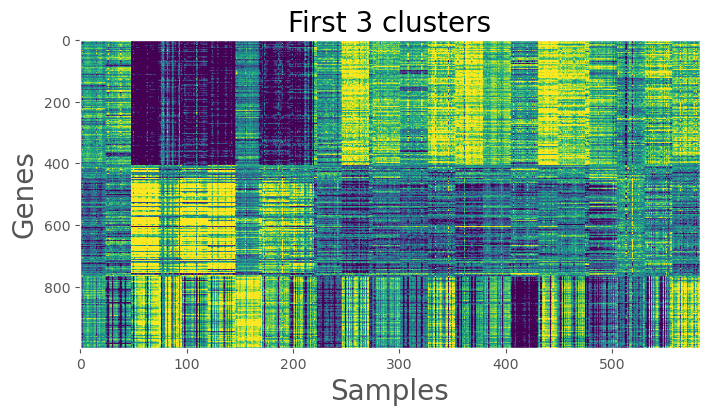

In [10]:
plt.figure(figsize=(8, 4))
plt.imshow(exp_data.loc[first_n_clusters,:], aspect="auto", cmap="viridis", vmin=-1, vmax=1)
plt.grid(False)
plt.ylabel("Genes", fontsize=20)
plt.xlabel("Samples", fontsize=20)
_= plt.title("First %d clusters" % FIRST_N, fontsize=20)

## II. Compute Mechanistic Inference

In [15]:
# get first principal component axes of clusters
axes = miner.principal_df(revised_clusters, exp_data, subkey=None, minNumberGenes=1)

# analyze revised clusters for enrichment in relational database
# (default: transcription factor binding site database)
mechanistic_output = miner.mechanisticInference(axes, revised_clusters, exp_data,
                                                correlationThreshold=MIN_CORRELATION,
                                                numCores=NUM_CORES,
                                                database_path=TFDB_PATH)

# order mechanisticOutput as dictionary of the form {tf: {coexpressionModule: genes } }
coregulation_modules = miner.getCoregulationModules(mechanistic_output)

# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulation_modules,
                             minNumberGenes=MIN_NUMBER_REGULON_GENES,
                             freqThreshold=0.333)

# reformat regulon dictionary for consistency with revisedClusters and coexpressionModules
regulon_modules, regulon_df = miner.regulonDictionary(regulons)

# define coexpression modules as composite of coexpressed regulons
coexpression_modules = miner.getCoexpressionModules(mechanistic_output)

# Get eigengenes for all modules
eigengenes = miner.getEigengenes(regulon_modules, exp_data, regulon_dict=None, saveFolder=None)
eigen_scale = np.percentile(exp_data, 95) / np.percentile(eigengenes, 95)
eigengenes = eigen_scale * eigengenes
eigengenes.index = np.array(eigengenes.index).astype(str)

# Write results to output directory
# write results to JSON files
miner.write_json(mechanistic_output, os.path.join(OUTPUT_DIR, "mechanisticOutput.json"))
miner.write_json(coregulation_modules, os.path.join(OUTPUT_DIR, "coregulationModules.json"))
miner.write_json(regulon_modules, os.path.join(OUTPUT_DIR, "regulons.json"))
miner.write_json(coexpression_modules, os.path.join(OUTPUT_DIR, "coexpressionModules.json"))

# write regulonDf to csv using preferred gene name identifiers
regulon_df.to_csv(os.path.join(OUTPUT_DIR, "regulonDf.csv"))

# write eigengenes to .csv
eigengenes.to_csv(os.path.join(OUTPUT_DIR,"eigengenes.csv"))

In [11]:
mechanistic_output = miner.read_json(os.path.join(OUTPUT_DIR, "mechanisticOutput.json"))
coregulation_modules = miner.read_json(os.path.join(OUTPUT_DIR, "coregulationModules.json"))
regulon_modules = miner.read_json(os.path.join(OUTPUT_DIR, "regulons.json"))
coexpression_modules = miner.read_json(os.path.join(OUTPUT_DIR, "coexpressionModules.json"))

# write regulonDf to csv using preferred gene name identifiers
regulon_df = pd.read_csv(os.path.join(OUTPUT_DIR, "regulonDf.csv"))

# write eigengenes to .csv
eigengenes = pd.read_csv(os.path.join(OUTPUT_DIR,"eigengenes.csv"))

## III. Compute Causal Inference

We have a set of three different mutation matrices. In this case, we perform causal network analysis on each of them individually and collect the results into a single result file

In [ ]:
# Load mutation matrices
common_mutations = pd.read_csv(os.path.join(DATA_DIR, "mutations", "commonMutations.csv"),
                               index_col=0, header=0)

translocations = pd.read_csv(os.path.join(DATA_DIR, "mutations", "translocationsIA12.csv"),
                             index_col=0, header=0)

cytogenetics = pd.read_csv(os.path.join(DATA_DIR, "mutations", "cytogenetics.csv"),
                           index_col=0, header=0)

# and perform causal analysis for each mutation matrix
reference_dictionary = regulon_modules
reference_regulon_df = regulon_df
reference_df = eigengenes
mut_matrices = [
    (common_mutations, "common_mutations"),
    (translocations, "translocations"),
    (cytogenetics, "cytogenetics") 
]
causal_directory = os.path.join(OUTPUT_DIR, "causal_analysis")

for mut_matrix, mut_name in mut_matrices:
    causalinf.causalNetworkAnalysis(regulon_matrix=reference_regulon_df.copy(),
                                    expression_matrix=exp_data.copy(),
                                    reference_matrix=reference_df.copy(),
                                    mutation_matrix=mut_matrix.copy(),
                                    resultsDirectory=causal_directory,
                                    minRegulons=1,
                                    significance_threshold=0.05,
                                    causalFolder="causal_results_" + mut_name)

# compile all causal results
causal_results = causalinf.readCausalFiles(causal_directory)
causal_results.to_csv(os.path.join(OUTPUT_DIR, "completeCausalResults.csv"))

# preview of the causal results
causal_results.head()

### Filter and write causal analysis results

for all causal flows

  * the regulon is differentially active w.r.t the mutation,
  * the regulator is differentially active w.r.t the mutation,
  * the regulator is significantly correlated to the regulon,
  * and the directionality of at least half of the differentially active targets 
  * downstream of the regulator are consistent with the perturbation from the mutation

In [14]:
causal_results_regulon_filtered = causal_results[
    causal_results["-log10(p)_Regulon_stratification"] >= -np.log10(0.05)]
causal_results_aligned = causal_results_regulon_filtered[
    causal_results_regulon_filtered.Fraction_of_edges_correctly_aligned>=0.5]
causal_results_aligned_correlated = causal_results_aligned[
    causal_results_aligned["RegulatorRegulon_Spearman_p-value"]<=0.05]
causal_results_stratified_aligned_correlated = causal_results_aligned_correlated[
    causal_results_aligned_correlated["-log10(p)_MutationRegulatorEdge"]>=-np.log10(0.05)]

causal_results_stratified_aligned_correlated.to_csv(os.path.join(OUTPUT_DIR, "filteredCausalResults.csv"))

## IV. Compute Network Mapping

In [12]:
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
reference_dictionary = regulon_modules

# create a background matrix used for statistical hypothesis testing
bkgd = miner.background_df(exp_data)

# for each cluster, give samples that show high coherent cluster activity
overexpressed_members = miner.biclusterMembershipDictionary(reference_dictionary, bkgd, label=2, p=0.05)

# for each cluster, give samples that show low coherent cluster activity
underexpressed_members = miner.biclusterMembershipDictionary(reference_dictionary, bkgd, label=0, p=0.05)

# write membership matrices to .csv file
overexpressed_members_matrix = miner.membershipToIncidence(overexpressed_members, exp_data)
overexpressed_members_matrix.to_csv(os.path.join(OUTPUT_DIR, "overExpressedMembers.csv"))

underexpressed_members_matrix = miner.membershipToIncidence(underexpressed_members, exp_data)
underexpressed_members_matrix.to_csv(os.path.join(OUTPUT_DIR, "underExpressedMembers.csv"))

### Visualize Network Activity across Individual Samples

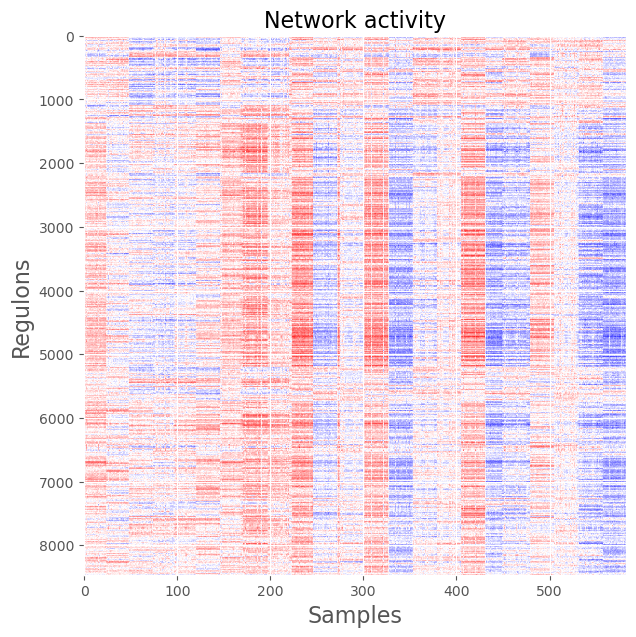

In [13]:
plt.figure(figsize=(7, 7))
network_activity_heatmap = overexpressed_members_matrix - underexpressed_members_matrix
plt.imshow(network_activity_heatmap, cmap="bwr", vmin=-1, vmax=1, aspect="auto")
plt.title("Network activity", fontsize=16)
plt.ylabel("Regulons", fontsize=16)
_ = plt.xlabel("Samples", fontsize=16)

## V. Subtype Discovery
### 1. Infer transcriptional States

In [14]:
min_cluster_size = int(np.ceil(0.01 * exp_data.shape[1]))
reference_matrix = overexpressed_members_matrix - underexpressed_members_matrix
primary_matrix = overexpressed_members_matrix
primary_dictionary = overexpressed_members
secondary_matrix = underexpressed_members_matrix
secondary_dictionary = underexpressed_members

states, centroid_clusters = subtypes.inferSubtypes(reference_matrix,
                                                primary_matrix,
                                                secondary_matrix,
                                                primary_dictionary,
                                                secondary_dictionary,
                                                minClusterSize=int(np.ceil(0.01 * exp_data.shape[1])),
                                                restricted_index=None)

states_dictionary = {str(i):states[i] for i in range(len(states))}
miner.write_json(states_dictionary, os.path.join(OUTPUT_DIR, "transcriptional_states.json"))

completed subtype inference in 0.39 minutes


### 2. Infer Transcriptional Programs

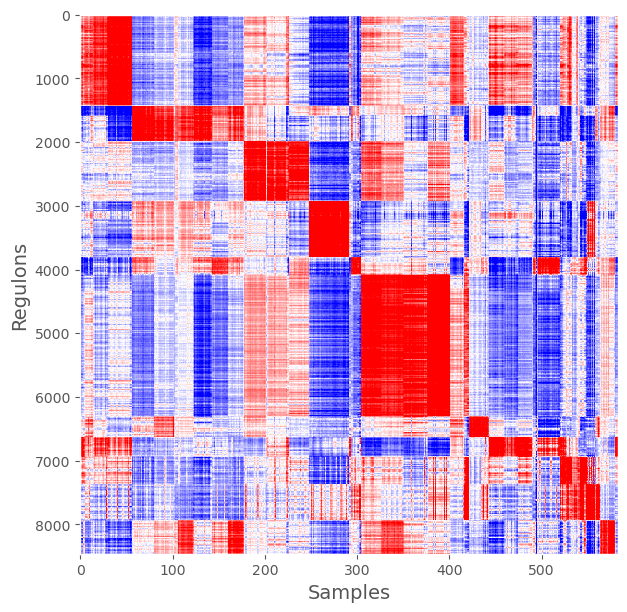

In [15]:
reference_df = eigengenes.copy()
programs, _ = miner.mosaic(dfr=reference_df,
                           clusterList=centroid_clusters,
                           minClusterSize_x=int(np.ceil(0.01 * exp_data.shape[1])),
                           minClusterSize_y=5,
                           allow_singletons=False,
                           max_groups=50,
                           saveFile=os.path.join(OUTPUT_DIR, "regulon_activity_heatmap.pdf"),
                           random_state=12)

reference_dictionary = {int(key) : value for key, value in reference_dictionary.items()}

transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs, reference_dictionary)
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
programs_dictionary = {str(i):program_list[i] for i in range(len(program_list))}
miner.write_json(programs_dictionary, os.path.join(OUTPUT_DIR, "transcriptional_programs.json"))
mosaic_df = reference_df.loc[np.hstack(program_list), np.hstack(states)]
mosaic_df.to_csv(os.path.join(OUTPUT_DIR, "regulons_activity_heatmap.csv"))

In [15]:
#transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs, reference_dictionary)
#program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
#programs_dictionary = {str(i):program_list[i] for i in range(len(program_list))}
#miner.write_json(programs_dictionary, os.path.join(OUTPUT_DIR, "transcriptional_programs.json"))
#mosaic_df = reference_df.loc[np.hstack(program_list), np.hstack(states)]
#mosaic_df.to_csv(os.path.join(OUTPUT_DIR, "regulons_activity_heatmap.csv"))

KeyError: 4175

In [16]:
dfr = overexpressed_members_matrix - underexpressed_members_matrix
mtrx = dfr.loc[np.hstack(program_list), np.hstack(states)]
plt.figure(figsize=(8, 8))
plt.imshow(mtrx, cmap="bwr", vmin=-1, vmax=1, aspect=float(mtrx.shape[1]) / float(mtrx.shape[0]))
plt.grid(False)
plt.savefig(os.path.join(OUTPUT_DIR, "mosaic_all.pdf"), bbox_inches="tight")

KeyError: "None of [Int64Index([4290, 4299, 4303, 4312, 4322, 4326, 4328, 4329, 4335, 4337,\n            ...\n            4094, 4108, 4119, 4127, 4150, 4173, 4196, 4202, 4208, 4307],\n           dtype='int64', length=8462)] are in the [index]"

In [17]:
# Determine activity of transcriptional programs in each sample
states_df = miner.reduceModules(df=dfr.loc[np.hstack(program_list), np.hstack(states)],
                                programs=program_list,
                                states=states,
                                stateThreshold=0.50,
                                saveFile=os.path.join(OUTPUT_DIR, "transcriptional_programs.pdf"))

# Cluster patients into subtypes and give the activity of each program in each subtype
programs_vs_states = miner.programsVsStates(states_df,
                                            states,
                                            filename=os.path.join(OUTPUT_DIR, "programs_vs_states.pdf"),
                                            showplot=True)

KeyError: "None of [Int64Index([4290, 4299, 4303, 4312, 4322, 4326, 4328, 4329, 4335, 4337,\n            ...\n            4094, 4108, 4119, 4127, 4150, 4173, 4196, 4202, 4208, 4307],\n           dtype='int64', length=8462)] are in the [index]"